In [129]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pypsa

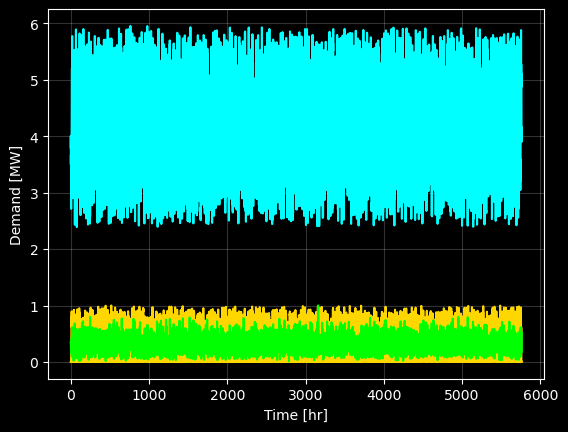

In [130]:
n_hours = 24  # hours per day
n_days = 240  # days to model
N = n_hours*n_days  # total number of time steps
phase_shift = 0  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
hours = np.linspace(0,N,N)
total_demand = 200*n_days/2  # [MWh], sets the total demand [units of energy]

demand = (np.sin((hours*np.pi/n_hours*2+phase_shift))*-1+np.ones(N)*(base_shift+1))

np.random.seed(1234) # sets the seed for repeatability

noise = np.random.random(N)
demand += noise

demand = demand/demand.sum() * total_demand  # rescale

phase_shift = 1
solar_power = (np.sin((hours*np.pi/n_hours*2+phase_shift))*-1)
solar_power += np.random.random(N)
solar_power /= solar_power.max()
solar_power[solar_power <0] = 0

shape_factor = 2.5
wind_speed = np.random.weibull(a=shape_factor,size=N)
wind_speed /= wind_speed.max()

with plt.style.context("dark_background"):
    plt.plot(hours, demand, color='cyan')
    plt.plot(hours, solar_power, color='gold')
    plt.plot(hours, wind_speed, color='lime')
    plt.ylabel('Demand [MW]')
    plt.xlabel('Time [hr]')
    plt.grid(alpha=0.2)
    plt.show()

In [131]:
n = pypsa.Network()

In [132]:
n.set_snapshots(range(N))

In [133]:
bus_name = 'Bus 01'
n.add(class_name="Bus",
      name=bus_name,
      carrier='AC')

n.add(class_name="Carrier", name="nuclear")
n.add(class_name="Carrier", name='wind')
n.add(class_name="Carrier", name="solar")
n.add(class_name="Carrier", name="battery")

In [134]:
n.add(
    class_name="Load",
    name=f"Load {bus_name}",
    bus=bus_name,
    p_set=demand
)

In [135]:
def annuity(r, n):
    return r / (1 - 1 / (1 + r)**n)

In [136]:
vre_lifetime = 20
nuclear_lifetime = 60

In [137]:
wind_fom = 29.264
wind_capex = 1407.953*annuity(0.07, vre_lifetime)
wind_annual = (wind_capex+wind_fom)*1e3 
solar_fom = 17.991
solar_capex = 1193.481*annuity(0.07, vre_lifetime)
solar_annual = (solar_fom + solar_capex)*1e3
battery_fom = 32.504
battery_capex = 1451.316*annuity(0.07, vre_lifetime)
battery_annual = (battery_fom + battery_capex) * 1e3
battery_duration = 4  # hours
nuclear_fom = 175
nuclear_capex = 7616.359*annuity(0.07, nuclear_lifetime)
nuclear_annual = (nuclear_fom+nuclear_capex)*1e3
nuclear_vom = 2.8  # $/MWh
nuclear_fuel = 5.37  # $/MWh
nuclear_marginal = nuclear_vom + nuclear_fuel  

In [138]:
n.add(class_name="Generator",
      name="UtilityPV",
      bus=bus_name,
      carrier='solar',
      p_min_pu=solar_power,
      p_max_pu=solar_power,
      capital_cost=solar_annual,  # $/MW
      p_nom_extendable=True)

n.add(class_name="Generator",
      name="LandWind",
      bus=bus_name,
      carrier='wind',
      p_min_pu=wind_speed,
      p_max_pu=wind_speed,
      capital_cost=wind_annual,
      p_nom_extendable=True)

n.add(class_name="Generator",
      name="Nuclear",
      carrier='nuclear',
      bus=bus_name,
      capital_cost=nuclear_annual,
      marginal_cost=nuclear_marginal,
      ramp_limit_up=0.05,
      ramp_limit_down=0.05,
      p_nom_extendable=True)

n.add(class_name="StorageUnit",
      name='Battery',
      bus=bus_name,
      carrier='battery',
      capital_cost=battery_annual,
      p_nom_extendable=True,
      max_hours=battery_duration,
      cyclic_state_of_charge=False)

In [139]:
n.optimize(solver_name='highs')

Index(['Bus 01'], dtype='object', name='Bus')
Index(['Bus 01'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 92.61it/s]
INFO:linopy.io: Writing time: 0.54s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 34564 primals, 92162 duals
Objective: 3.27e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Generator-ext-p-ramp_limit_up, Generator-ext-p-ramp_limit_down, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned t

('ok', 'optimal')

In [146]:
stats = n.statistics()
stats

Optimal Capacity  Installed Capacity       Supply  \
Generator   nuclear           1.99483                 0.0  10092.58905   
            solar             1.98864                 0.0   3583.18766   
            wind              5.55113                 0.0  10324.22329   
Load        -                 0.00000                 0.0      0.00000   
StorageUnit battery           3.54214                 0.0   2391.32539   

                      Withdrawal  Energy Balance Transmission  \
Generator   nuclear      0.00000     10092.58905          0.0   
            solar        0.00000      3583.18766          0.0   
            wind         0.00000     10324.22329          0.0   
Load        -        24000.00000    -24000.00000          0.0   
StorageUnit battery   2391.32539         0.00000          0.0   

                     Capacity Factor  Curtailment  Capital Expenditure  \
Generator   nuclear         0.878366   1397.62487         1.431304e+06   
            solar           0.312817      0.00000         2.598104e+05   
            wind            0.322889      0.00000         9.001976e+05   
Load        -                    NaN      0.00000         0.000000e+00   
StorageUnit battery         0.234412  20402.74280         6.003860e+05   

                     Operational Expenditure       Revenue  Market Value  
Generator   nuclear              82456.45252  1.513761e+06    149.986982  
            solar                    0.00000  2.598104e+05     72.508311  
            wind                     0.00000  9.001976e+05     87.192764  
Load        -                        0.00000 -3.274155e+06           NaN  
StorageUnit battery                  0.00000  6.003860e+05    251.068696

In [141]:
TECH_ORDER = ['nuclear',
              'wind',
              'solar',
            #   'battery'
              ]

In [142]:
def power_by_carrier(n):
    p_by_carrier = n.generators_t.p.T.groupby(
        n.generators.carrier).sum().T 
    
    if not n.storage_units.empty:
        sto = n.storage_units_t.p.T.groupby(
            n.storage_units.carrier).sum().T
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)
        
    last_cols = [col for col in p_by_carrier.columns if col not in TECH_ORDER]

    p_by_carrier = p_by_carrier[TECH_ORDER+last_cols]

    return p_by_carrier

In [143]:
pbc = power_by_carrier(n)

c:\Users\sdotson\AppData\Local\miniforge3\envs\pypsa-illinois-test05\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1794: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



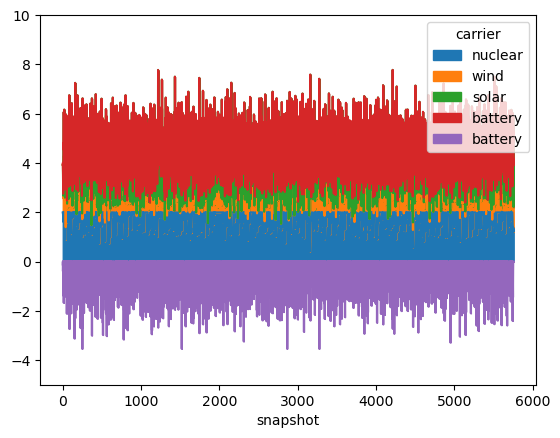

In [144]:
fig, ax = plt.subplots()
pbc.where(pbc>0).dropna(how='all', axis=1).plot.area(ax=ax)
pbc.where(pbc<0).dropna(how='all', axis=1).plot.area(ax=ax)
ax.set_ylim(-5, 10)
plt.show()